In [2]:
# Imports and read the simpson data in
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import datetime

## Preprocessing

In [3]:
simpsons_df = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False, index_col='id')

def dict_from_csv(csv_file_name):
    with open(csv_file_name, mode='r') as infile:
        next(infile)
        reader = csv.reader(infile)
        return_dict = {int(rows[0]):rows[1] for rows in reader}
        return return_dict

character_dict = dict_from_csv('simpsons_characters.csv')
location_dict = dict_from_csv('simpsons_locations.csv') 

#### Remove unneeded data from the dataset

In [3]:
# Clear up the data
# We need to have value in character_id, location_id, and normalized_text so we drop nan rows
simpsons_df = simpsons_df.dropna(subset=['character_id', 'location_id', 'normalized_text'])
# In number, timestamp_in_ms, raw_text, and speaking_line we have no extra information so we drop those columns
simpsons_df = simpsons_df.drop(['number', 'timestamp_in_ms', 'raw_text', 'speaking_line'], axis=1)
# Change numeric values to numeric
simpsons_df['character_id'] = pd.to_numeric(simpsons_df['character_id'])
simpsons_df['location_id'] = pd.to_numeric(simpsons_df['location_id'], downcast='integer')
simpsons_df['word_count'] = pd.to_numeric(simpsons_df['word_count'], downcast='integer')

#### Decrease the number of characters we use

In [4]:
# Count how many lines each character has
character_line_counts = Counter(simpsons_df['character_id']).most_common()

most_common_characters = []

# If character has fewer than 200 lines we will not inlcude that character
for character in character_line_counts:
    if character[1] >= 200:
        most_common_characters.append(character[0])
simpsons_df = simpsons_df[simpsons_df['character_id'].isin(most_common_characters)]

temp_dict = {character: character_dict[character] for character in most_common_characters}
character_dict = temp_dict

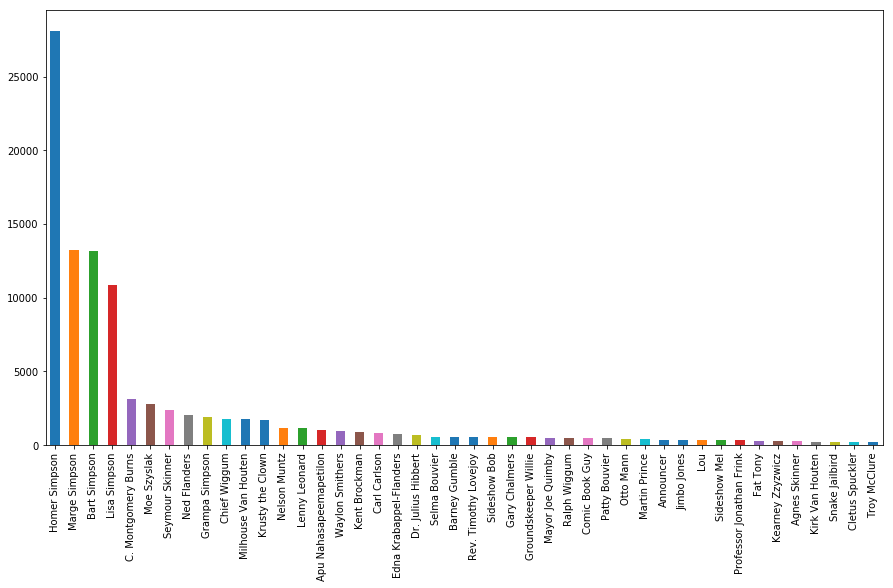

In [5]:
# Here we count how many sentences each character has 
value_counts = simpsons_df['character_id'].value_counts()
# Plot a bar plot with the counts
count_plot = value_counts.plot(kind='bar', figsize=(15,8))
# Change the ID of thoose characters to names
count_plot.set_xticklabels([character_dict[i] for i in value_counts.keys()])
plt.show()

In [6]:
simpsons_df['character_id'].value_counts(normalize=True)

2       0.281910
1       0.133069
8       0.132277
9       0.109110
15      0.031303
17      0.028163
3       0.023949
11      0.020598
31      0.018762
71      0.018019
25      0.018009
139     0.017076
101     0.011488
165     0.011468
208     0.009913
14      0.009682
211     0.008618
170     0.008538
40      0.007625
332     0.006752
22      0.005679
18      0.005578
140     0.005558
153     0.005287
1078    0.005207
404     0.005167
240     0.004926
119     0.004706
801     0.004645
10      0.004635
52      0.004083
38      0.003883
33      0.003652
144     0.003471
91      0.003441
699     0.003401
442     0.003301
568     0.002769
145     0.002589
192     0.002558
817     0.002378
518     0.002318
1413    0.002257
426     0.002177
Name: character_id, dtype: float64

#### Represent data as vector space model

In [7]:
# Min_df is the minimum amount of toke frequency to be kept
# stop_words is to skip words like 'a, the' etc.
# sublinear_tf is used so we can do sublinear tf scaling (replace tf with 1+log(tf))
# Norm L2 is L2-normalization to minimize single outliers
# ngram_range is 1,3 so we select tokens of wordsizes: 1, 2 and 3

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english', norm='l2', ngram_range=(1,3))

features = tfidf.fit_transform(simpsons_df.normalized_text)
labels = simpsons_df.character_id
features.shape

(99670, 16239)

#### Show the most popular Grams each person says

In [8]:
most_popular_df = pd.DataFrame()
# Get the 5 most popular tokens
token_count = 5
tokenNames = ['Token ' + str(i) for i in range(1, token_count+1)]

for character_id in character_dict:
    features_chi2 = chi2(features, labels == character_id)
    # Here the we sort the most common features of each character in order
    # features_chi2[0] stands for chi statistics of each character
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # Split features in single or two word grams
    unigrams = [word for word in feature_names if len(word.split(' ')) == 1]
    biggrams = [words for words in feature_names if len(words.split(' ')) == 2]
    
    # If we don't have enough tokens for any charater we fill it with nan 
    if len(unigrams) < token_count:
        for i in range(len(unigrams), token_count+1):
            unigrams.append(np.nan)
    if len(biggrams) < token_count:
        for i in range(len(biggrams), token_count+1):
            biggrams.append(np.nan)
    
    # Append most common single word tokens to the dataframe
    character = "UNI: " + character_dict[character_id]
    most_popular_df = most_popular_df.append(
        pd.DataFrame([unigrams[-token_count:]], index=[character], columns=tokenNames))
    # Append the most common two word tokens to the dataframe
    character = "BIG: " + character_dict[character_id]                                          
    most_popular_df = most_popular_df.append(pd.DataFrame([biggrams[-token_count:]], index=[character], columns=tokenNames))
                                               
most_popular_df.head(10)

,Token 1,Token 2,Token 3,Token 4,Token 5
UNI: Homer Simpson,dad,homer,hoo,woo,marge
BIG: Homer Simpson,marge youre,heh heh,marge im,oh marge,woo hoo
UNI: Marge Simpson,dad,hey,husband,homer,homie
BIG: Marge Simpson,homer stop,homer dont,homie im,oh homer,oh homie
UNI: Bart Simpson,cool,carumba,milhouse,dad,lis
BIG: Bart Simpson,im bart,aye carumba,hey dad,hey lis,ay carumba
UNI: Lisa Simpson,marge,homer,bart,mom,dad
BIG: Lisa Simpson,dad youre,oh dad,dad dont,mom dad,dad thats
UNI: C. Montgomery Burns,hounds,simpson,bah,excellent,smithers
BIG: C. Montgomery Burns,ahoy hoy,look smithers,oh smithers,smithers im,simpson eh


#### Splitting the data

In [9]:
x_train, x_test, y_train, y_test = train_test_split(simpsons_df['normalized_text'], simpsons_df['character_id'], random_state=42, test_size=0.2)
x_train_vec = tfidf.fit_transform(x_train)
x_test_vec = tfidf.transform(x_test)

## Model selection

In [10]:
def best_params(x,y, param_grid, classifier):
    grid_search = GridSearchCV(classifier, param_grid, n_jobs=6)
    grid_search.fit(x,y)
    return grid_search

def print_cnf_matrix(test, prediction):
    cnf_matrix = confusion_matrix(test, prediction)
    plt.subplots(figsize=(15,8))
    sns.heatmap(cnf_matrix, annot=False, fmt='d', vmax=100, cmap='GnBu')
    plt.show()
    
def best_results(grid_search):
    test_prediction = grid_search.best_estimator_.predict(x_test_vec)
    print("The accuracy is:", accuracy_score(y_test, test_prediction))
    print("For parameters:", grid_search.best_params_)
    print_cnf_matrix(y_test, test_prediction)

grid_search_dict = {}

#### Naive Bayes

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The accuracy is: 0.35156014849001704
For parameters: {'alpha': 0.33684210526315794, 'fit_prior': True}


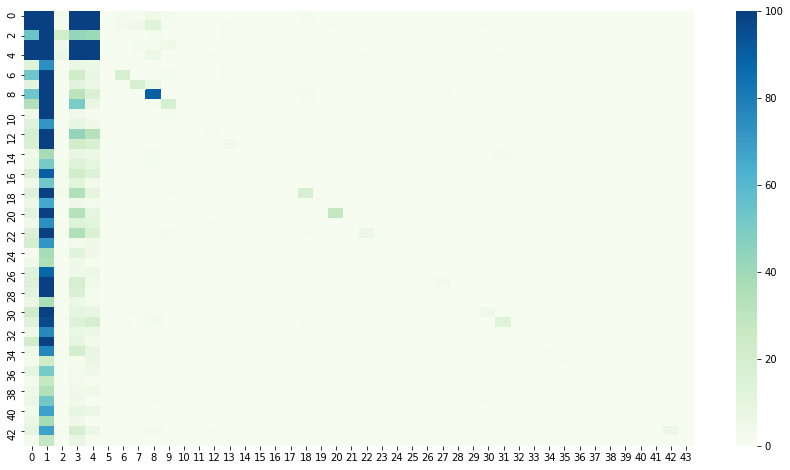

2018-10-08 13:48:50.048854


In [11]:
alpha = []
fit_prior = [True, False]

alpha.extend(list(np.linspace(0.01, 0.1, 20)))
alpha.extend(list(np.linspace(0.1,1,20)))
alpha.extend([current for current in range(1, 10)])
alpha.extend([10, 20, 30, 40, 50, 100])


mnb = MultinomialNB()
param_grid = dict()
param_grid = {'alpha':alpha, 'fit_prior':fit_prior}


grid_search = best_params(x_train_vec, y_train, param_grid, mnb)
grid_search_dict['nb_grid'] = grid_search

best_results(grid_search)
print(datetime.datetime.now())

#### Linear Support Vector Machine

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The accuracy is: 0.368566268686666
For parameters: {'C': 0.09526315789473684}


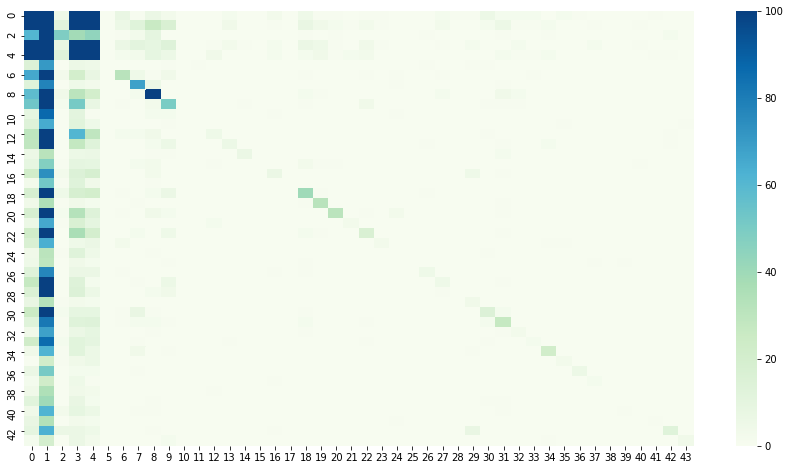

2018-10-08 13:51:50.212978


In [12]:
Cs = [] 
Cs.extend(list(np.linspace(0.01, 0.1, 20)))
Cs.extend(list(np.linspace(0.1,1,20)))
Cs.extend([current for current in range(1, 10)])

svc = LinearSVC()
param_grid = dict()
param_grid = {'C':Cs}

grid_search = best_params(x_train_vec, y_train, param_grid, svc)
grid_search_dict['svc_grid'] = grid_search

best_results(grid_search)
print(datetime.datetime.now())

#### LogisticRegression

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The accuracy is: 0.3644526938898365
For parameters: {'C': 2}


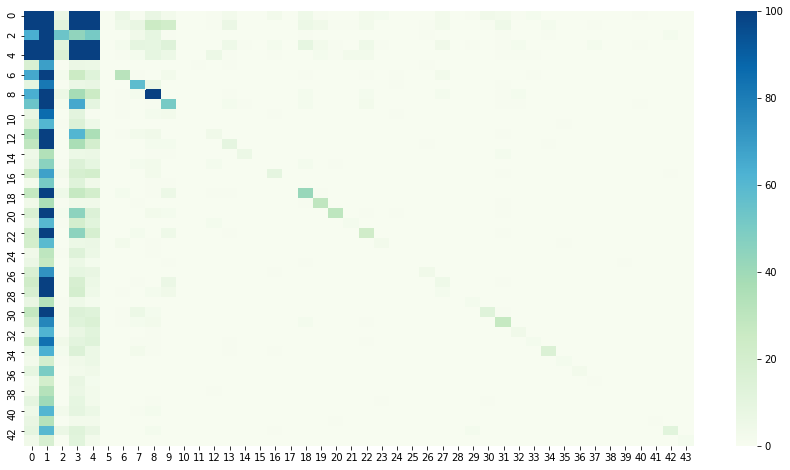

2018-10-08 13:56:48.294663


In [13]:
param_grid = dict()
param_grid ={'C':Cs}

lrc = LogisticRegression()

grid_search = best_params(x_train_vec, y_train, param_grid, lrc)

grid_search_dict['lr_grid'] = grid_search
best_results(grid_search)
print(datetime.datetime.now())

#### K-Nearest Neighbor

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The accuracy is: 0.29848500050165544
For parameters: {'n_neighbors': 80}


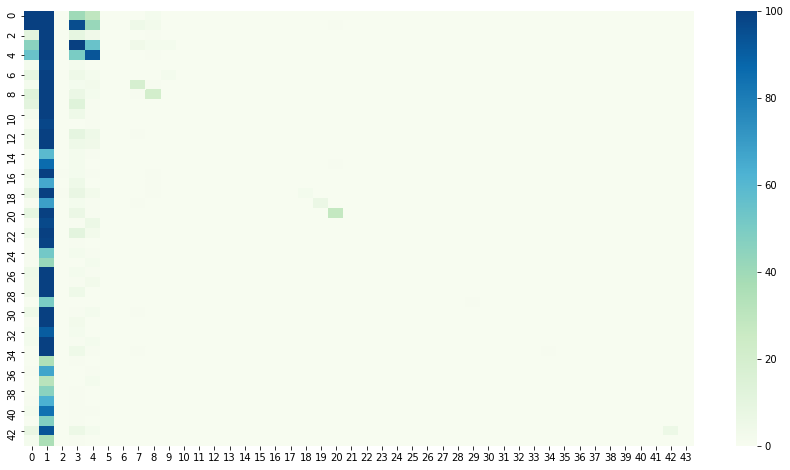

2018-10-08 15:30:04.032599


In [17]:
n_neighbors = [i for i in range(1,21)]
n_neighbors.extend([i for i in range(20, 51, 5)])
n_neighbors.extend([i for i in range(50, 201, 10)])
knn = KNeighborsClassifier()
param_grid = dict()
param_grid = {'n_neighbors':n_neighbors}

grid_search = best_params(x_train_vec, y_train, param_grid, knn)

grid_search_dict['knn_grid'] = grid_search

best_results(grid_search)
print(datetime.datetime.now())

## Plotting gridSearch

In [37]:
def plot_grid_search(grid, title, param):
    grid_df = pd.DataFrame(grid.cv_results_)
    grid_df.plot(x=param, y='mean_test_score', figsize=(15,8), style='.-', title=title)

#### Naive bayes

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=

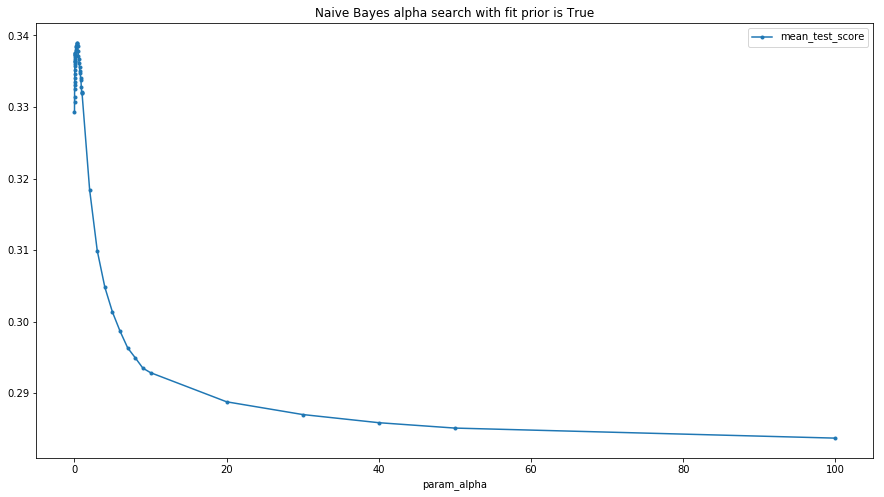

In [55]:
nb_df = pd.DataFrame(grid_search_dict['nb_grid'].cv_results_)
nb_t_df = nb_df[nb_df.param_fit_prior == True]
nb_f_df = nb_df[nb_df.param_fit_prior == False]

nb_t_df.plot(x='param_alpha', y='mean_test_score', 
             figsize=(15,8), style='.-', title='Naive Bayes alpha search with fit prior is True')

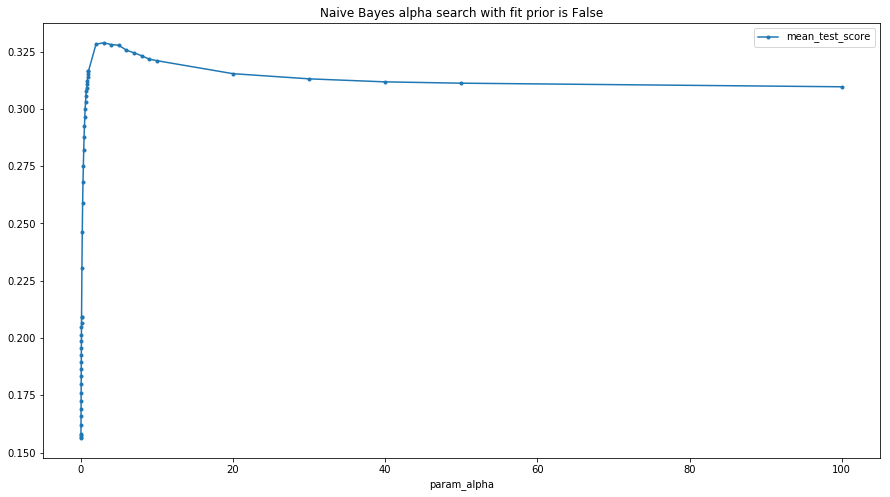

In [56]:
nb_f_df.plot(x='param_alpha', y='mean_test_score', 
             figsize=(15,8), style='.-', title='Naive Bayes alpha search with fit prior is False')

#### Linear Support Vector Machine

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=

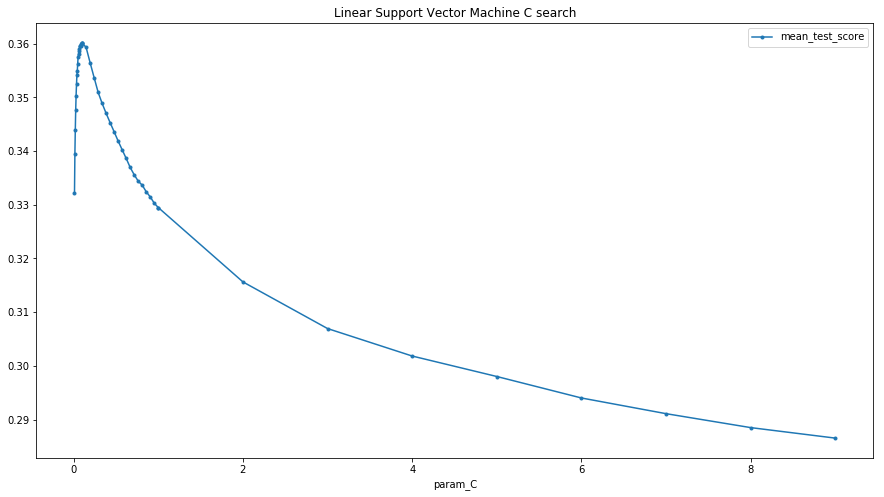

In [39]:
plot_grid_search(grid_search_dict['svc_grid'], 'Linear Support Vector Machine C search', 'param_C')   

#### Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=

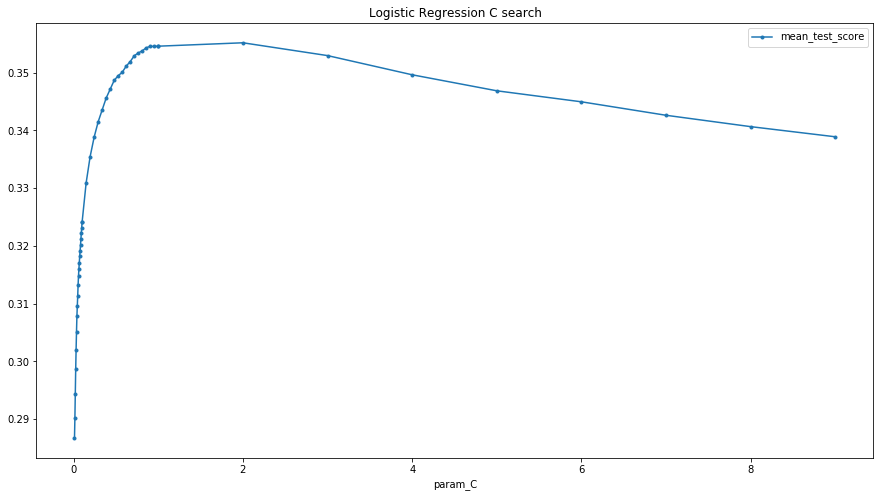

In [40]:
plot_grid_search(grid_search_dict['lr_grid'], 'Logistic Regression C search', 'param_C')   

#### K-Nearest Neighbor

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=

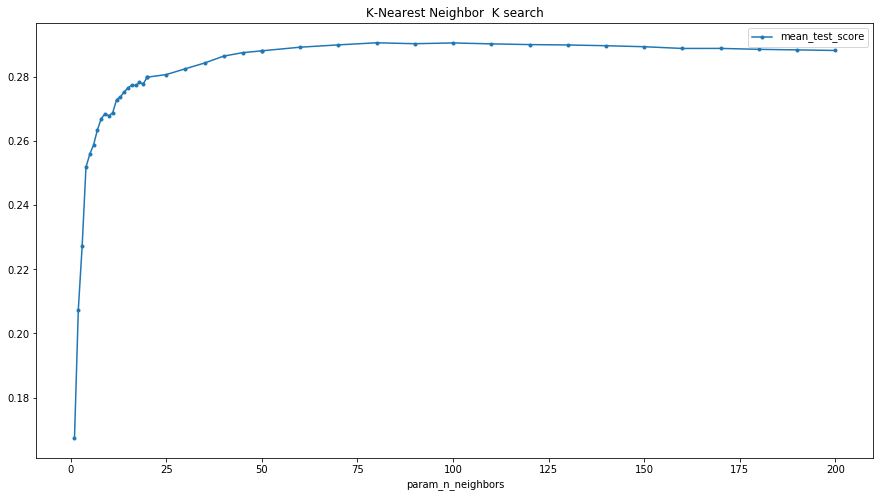

In [44]:
plot_grid_search(grid_search_dict['knn_grid'], 'K-Nearest Neighbor  K search', 'param_n_neighbors')   